# Normalization techniques

Explore different normalization techniques, adapted from large scale imagery to simplistic examples using 2d arrays

Original inspiration for the techniques applied :
- https://medium.com/sentinel-hub/how-to-normalize-satellite-images-for-deep-learning-d5b668c885af (linear normalization)
- https://arxiv.org/ftp/arxiv/papers/1710/1710.02939.pdf (gaussian and norm 2)
- https://www.nature.com/articles/s41597-022-01307-4 (dynamic world)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler # Rescale arrays to 0, 100
from skimage import exposure
import scipy.stats as stats # Z-score normalization

os.chdir("/home/empathyforgiveness/max_website/max-website/_data/assets/images/normalization_distributions")

## Notebook structure

- Create functions for histogram creation and normalization techniques
- Create 3 arrays (normal distribution, left skew, right skew)
- Visualize (plot) each type of distribution after with each normalization technique

In [2]:
def plot_histogram(arrays, titles: str, norm_type: str):
    
    num_plots = len(arrays)
    fig, axes = plt.subplots(1, num_plots, figsize=(5*num_plots, 5))
    
    plt.suptitle(norm_type)

    for i in range(num_plots):
        axes[i].hist(arrays[i], bins='auto')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(titles[i])

    plt.tight_layout()

    plt.savefig(f'histogram_{norm_type}.png')
    #plt.show()


### Standard linear normalization
- The lower and upper bounds are set to 0, 1 respectively
- We set 1st and 99th percentile parameters (this will reduce outlier influence, can cause shift in the transformed distribution when skewed data)

In [3]:
def linear_normalization(array: np.ndarray):
    """
    Description : 
        Linear normalization of an array (with optional clipping)

    Parameters:
        array : numpy array
            The array to normalize

    Returns:
        numpy array
            The normalized array

    """

    # Set the maximum value to the 99th percentile
    max_value = np.percentile(array, 98)

    # Set the minimum value to the 1st percentile
    min_value = np.percentile(array, 2)

    # Set a bounds for the normalization
    a_lower, b_upper = 0, 1 

    return ((array - min_value)) * ( ( b_upper - a_lower ) / (max_value - min_value) ) + a_lower

### Dynamic world normalization

https://www.nature.com/articles/s41597-022-01307-4

In [4]:
def dynamic_world_normalization(array: np.ndarray, percentiles: list):
    
    lp, up = percentiles
    
    # First log transform the image
    epsilon = 1e-6  # A small value to avoid log(0)
    log_array = np.log(array * 0.005 + 1 + epsilon)

    # Obtain low/upper-percentiles for current channel
    lower_percentile = np.percentile(log_array, lp)
    upper_percentile = np.percentile(log_array, up)

    # Normalize the image adjusting its scale with the percentile bounds
    normalized_array = (log_array - lower_percentile) / (upper_percentile - lower_percentile)

    # Apply the sigmoid function to the image (transforms values to sigmoid function)
    normalized_array = 1 / (1 + np.exp(-normalized_array * 2))

    return normalized_array

### Histogram Equalization

Applications of this method in image transformation can be seen (and explained) in more detail here :
- https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html

In [5]:
def histogram_normalization(array: np.ndarray, extra_specs: str = "Equalization"):

    if extra_specs == "Equalization":
        array = exposure.equalize_hist(array)
        return array

    elif extra_specs == "Adaptive_Equalization":
        array = exposure.equalize_adapthist(array, clip_limit=0.03)
        return array

In [6]:
def histogram_equalization(array: np.ndarray):
    # Step 1: Calculate histogram
    hist, bins = np.histogram(array, bins=100, range=(0, 99))
    
    # Step 2: Calculate cumulative distribution function (CDF)
    cdf = hist.cumsum()
    
    # Step 3: Normalize the CDF
    cdf_normalized = (cdf - cdf.min()) * 100 / (cdf.max() - cdf.min())
    cdf_normalized = cdf_normalized.astype('uint8')
    
    # Step 4: Use the normalized CDF to transform the original array
    equalized_arr = np.interp(array, bins[:-1], cdf_normalized)
    
    return equalized_arr

### Gaussian normalization (standardization)

Paper : 
- https://arxiv.org/ftp/arxiv/papers/1710/1710.02939.pdf

In [7]:
def gaussian_normalization(array: np.ndarray):

    array = stats.zscore(array)
    return array

### Norm 2

Paper :
- https://arxiv.org/ftp/arxiv/papers/1710/1710.02939.pdf

In [8]:
def norm2_normalization(array: np.ndarray):

    array = np.array(array)
    array = array / np.sqrt(np.sum(array**2))
    return array

## Section 2:

- Histogram creation
- Visualizations

In [9]:
# Set a seed for reproducability
np.random.seed(80)

# Create the baseline distributions
normal_array = np.random.normal(loc=0, scale=1, size=1000)
right_skewed_array = np.random.gamma(shape=2, scale=2, size=1000)
left_skewed_array = -np.random.gamma(shape=2, scale=2, size=1000)

# Create a scaler for rescaling using min-max scaling to [0, 100]
def rescale(array):
    scaler = MinMaxScaler(feature_range=(0, 100))
    scaled_values = scaler.fit_transform(array.reshape(-1, 1)) # Reshape to 2D array
    return scaled_values.flatten() # Return to 1D array

# Rescale the arrays
normal_array = rescale(normal_array).astype(float)
right_skewed_array = rescale(right_skewed_array).astype(float)
left_skewed_array = rescale(left_skewed_array).astype(float)

# Array list
arrays = [normal_array, right_skewed_array, left_skewed_array]

# Title list
titles = ['Normal Distribution', 'Right Skewed Distribution', 'Left Skewed Distribution']

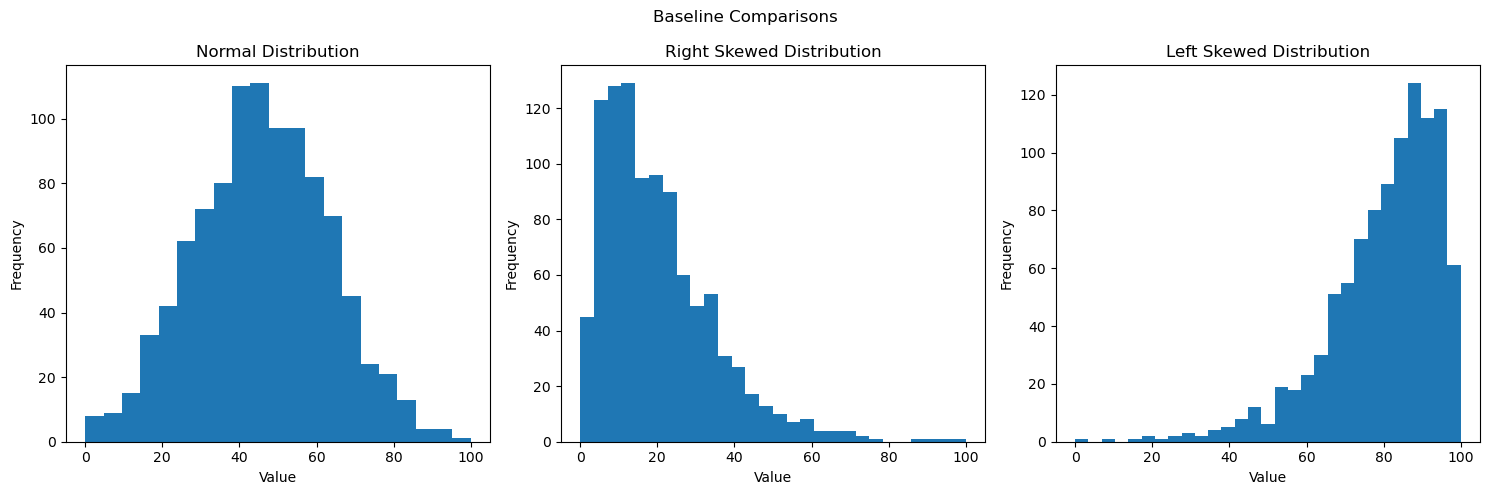

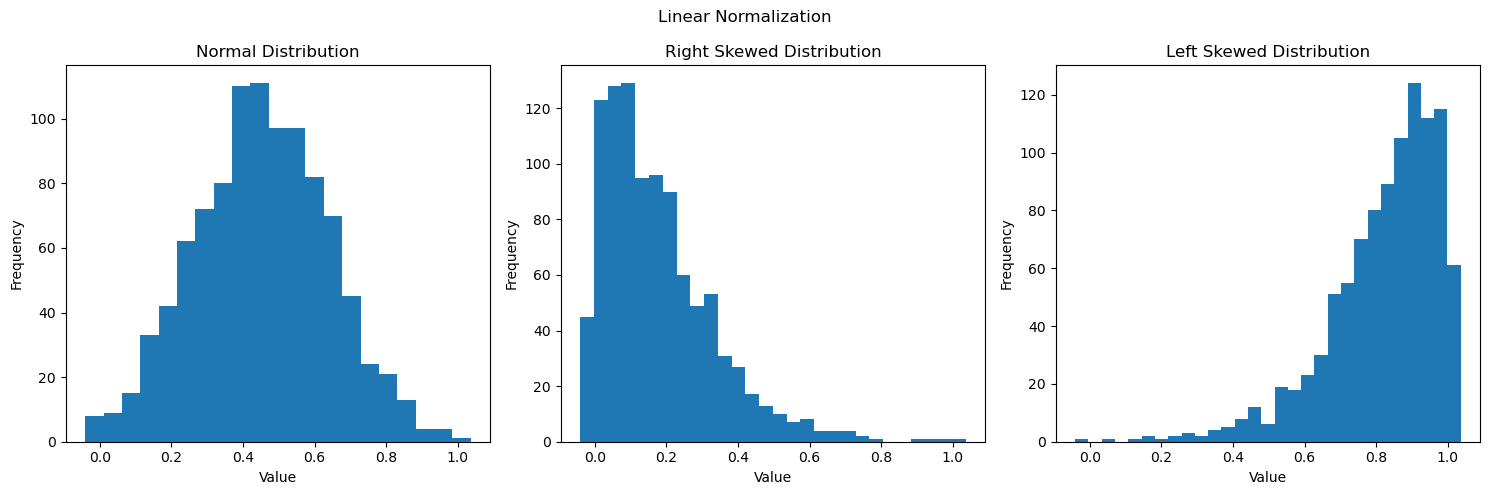

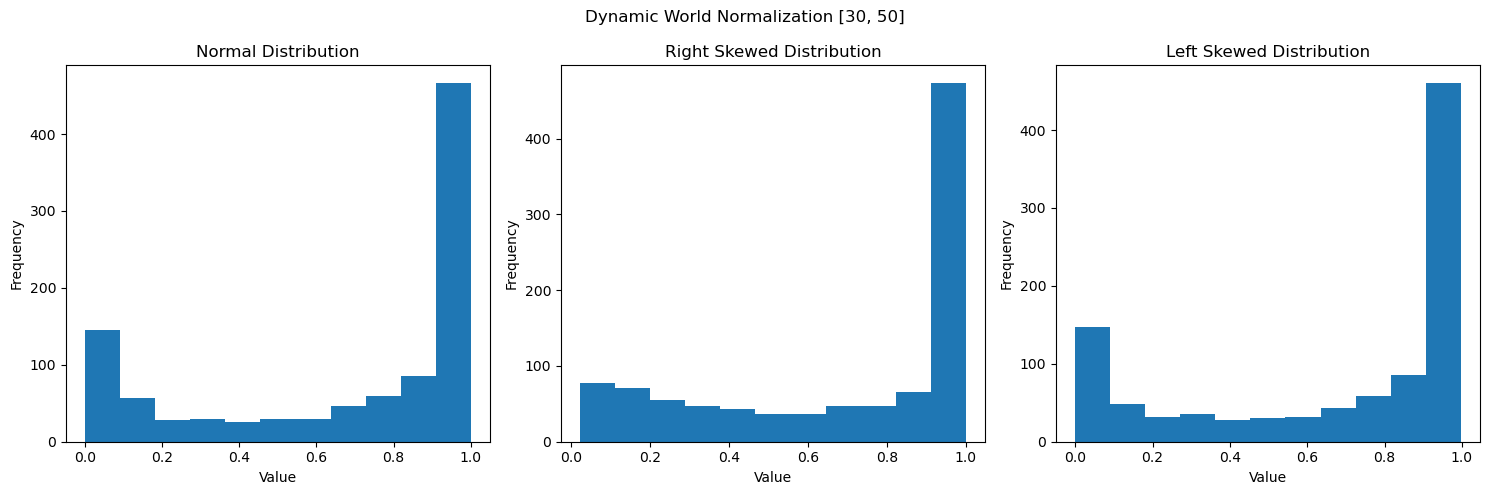

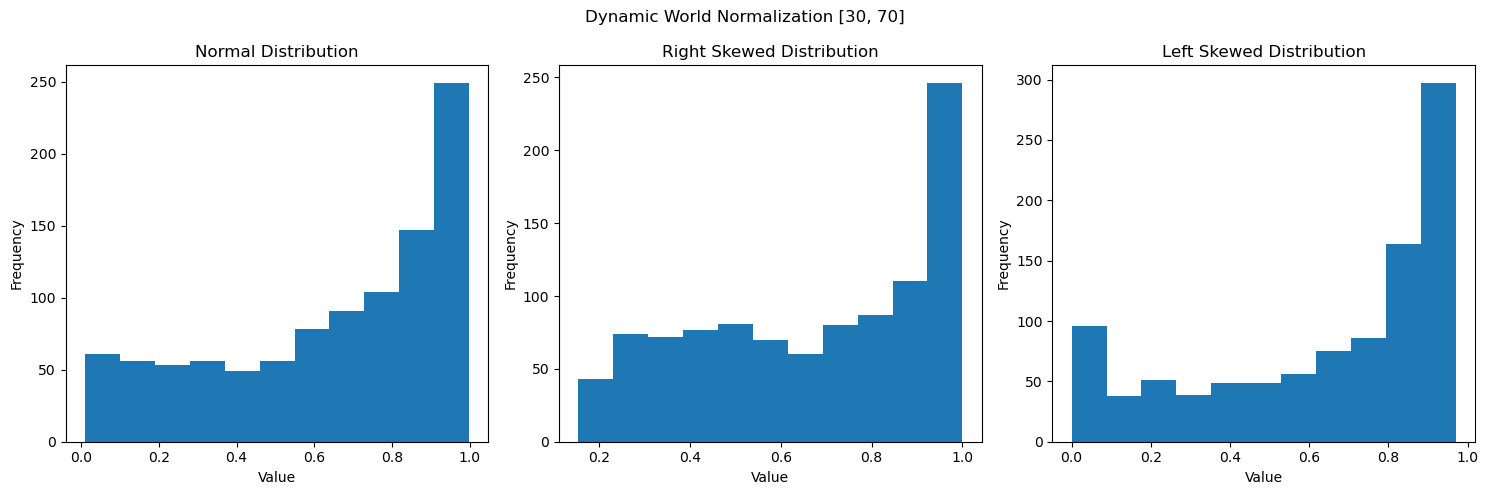

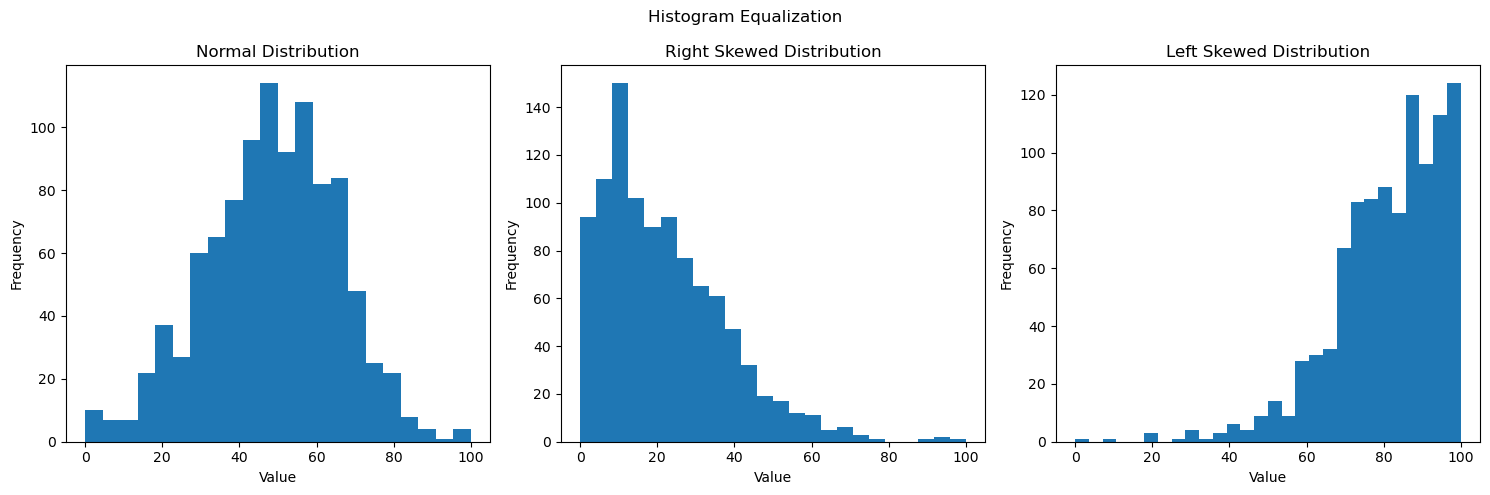

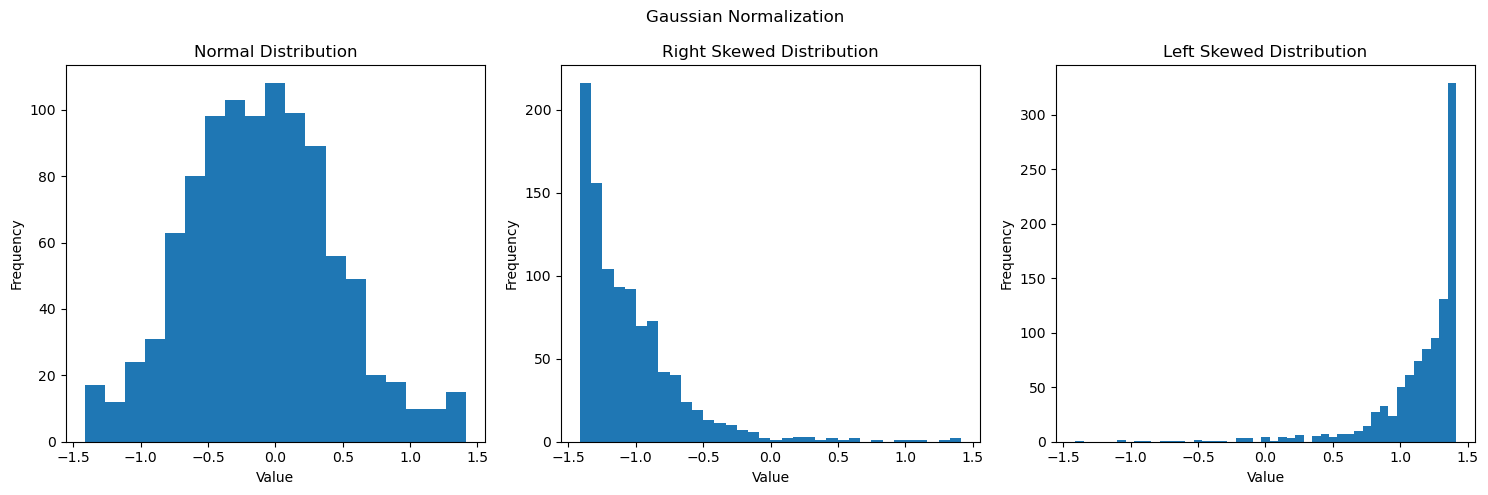

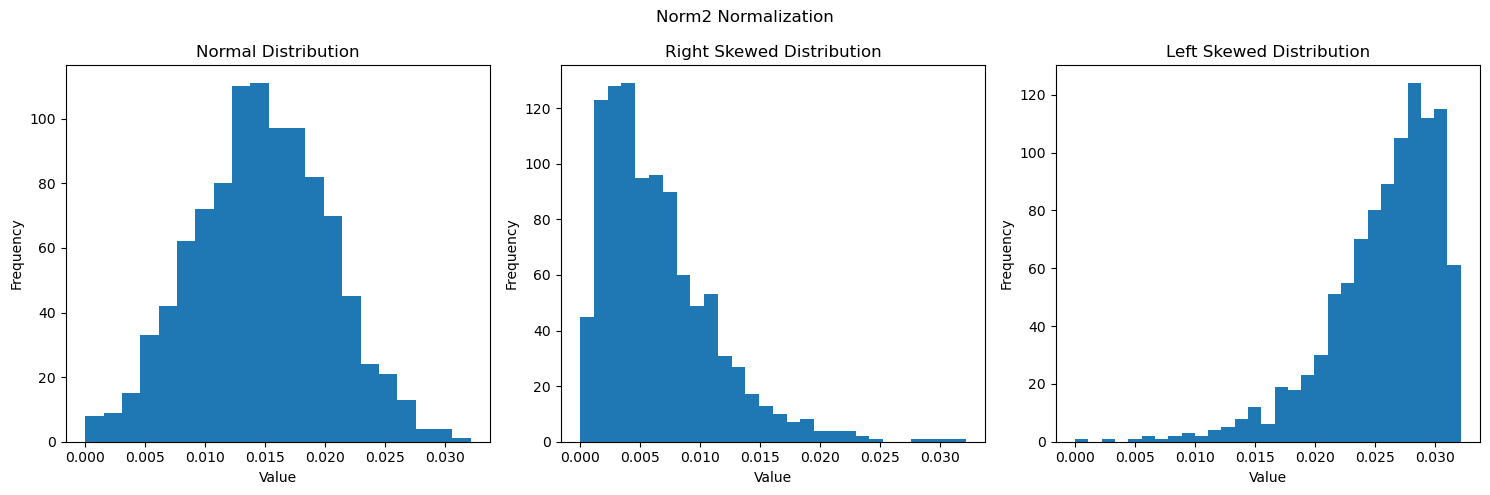

In [10]:
plot_histogram(arrays, titles, norm_type = 'Baseline Comparisons')
linear_norm_array = linear_normalization(arrays)
plot_histogram(linear_norm_array, titles, norm_type = 'Linear Normalization')
dynamic_world_normalization_3050 = [dynamic_world_normalization(arr, [30, 50]) for arr in arrays]
dynamic_world_normalization_3070 = [dynamic_world_normalization(arr, [30, 70]) for arr in arrays]
plot_histogram(dynamic_world_normalization_3050, titles, norm_type = 'Dynamic World Normalization [30, 50]')
plot_histogram(dynamic_world_normalization_3070, titles, norm_type = 'Dynamic World Normalization [30, 70]')
histogram_normalization_array_equalization = histogram_equalization(arrays)
# histogram_normalization_array_adaptive_equalization = histogram_normalization(arrays, extra_specs = "Adaptive_Equalization")
plot_histogram(histogram_normalization_array_equalization, titles, norm_type = 'Histogram Equalization')
# plot_histogram(histogram_normalization_array_adaptive_equalization, titles, norm_type = 'Adaptive Histogram Equalization')
gaussian_normalization_array = gaussian_normalization(arrays)
plot_histogram(gaussian_normalization_array, titles, norm_type = 'Gaussian Normalization')
norm2_normalization_array = norm2_normalization(arrays)
plot_histogram(norm2_normalization_array, titles, norm_type = 'Norm2 Normalization')


In [11]:
import cv2
from matplotlib import pyplot as plt
os.chdir("/home/empathyforgiveness/max_website/max-website/")

In [12]:
def grayscale_histogram(array):
    print(type(array))
    hist = cv2.calcHist([array], [0], None, [256], [0, 256])
    plt.figure()
    plt.title('Grayscale Histogram')
    plt.ylabel('# of Pixels')
    plt.xlabel('Value')
    plt.plot(hist)

(2016, 1512, 3)
(2016, 1512)


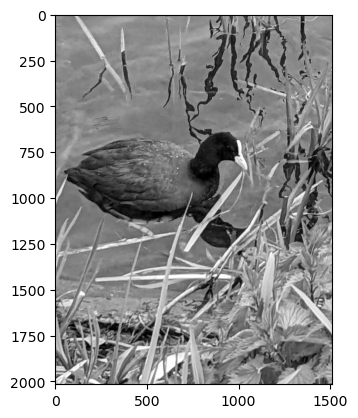

In [13]:
img = cv2.imread('loon_picture_bird.jpeg', cv2.IMREAD_UNCHANGED)
print(img.shape)
b,g,r = cv2.split(img)
g2 = g.copy()

print(g2.shape)

# Channel (1, here green, BGR) has highest reflectance, best for seeing contrast
plt.imshow(g2, cmap='gray')

In [16]:
os.chdir("/home/empathyforgiveness/max_website/max-website/assets/imgs")

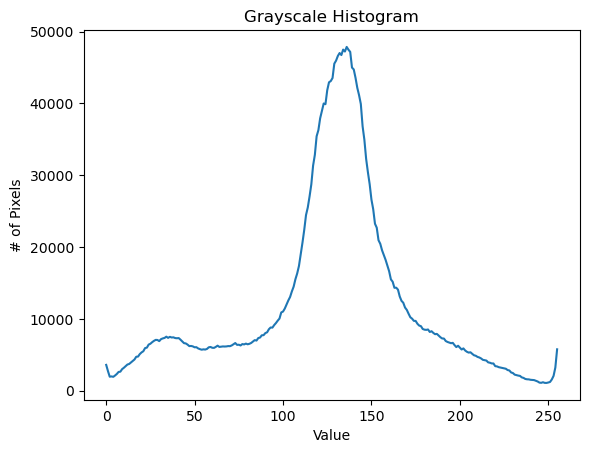

In [17]:
baseline_hist = cv2.calcHist([g2], [0], None, [256], [0, 256])
plt.figure()
plt.title('Grayscale Histogram')
plt.ylabel('# of Pixels')
plt.xlabel('Value')
plt.plot(baseline_hist)
plt.savefig("baseline_histogram.jpeg")

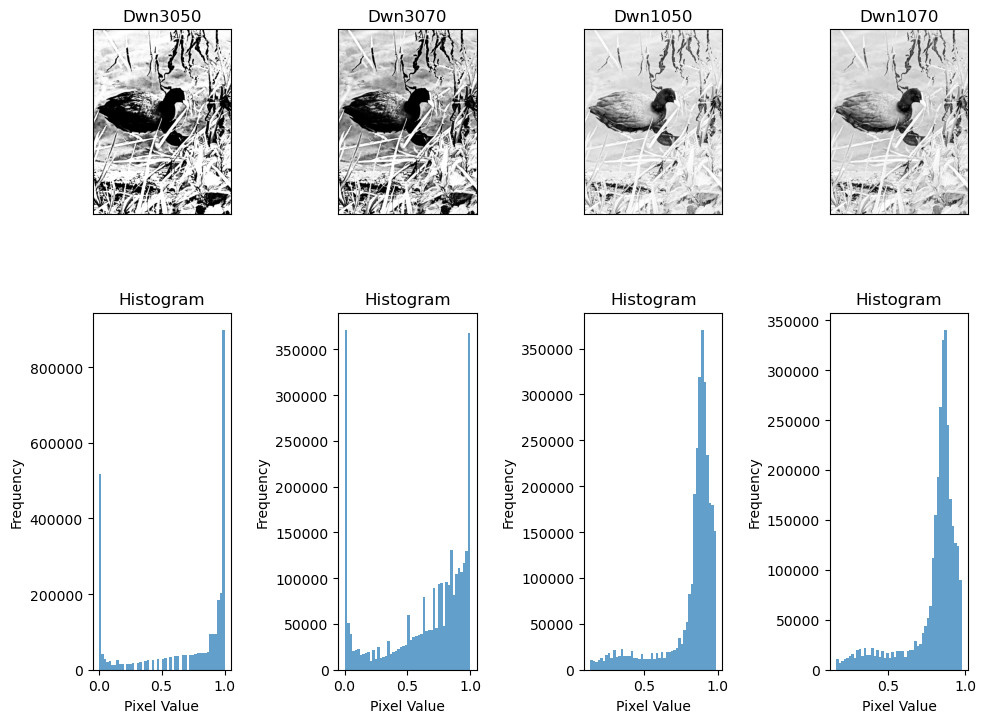

In [19]:
dwn3050 = dynamic_world_normalization(g2, [30, 50])
dwn3070 = dynamic_world_normalization(g2, [30, 70])
dwn1050 = dynamic_world_normalization(g2, [10, 50])
dwn1070 = dynamic_world_normalization(g2, [10, 70])

dwn3050flat = dwn3050.flatten()
dwn3070flat = dwn3070.flatten()
dwn1050flat = dwn1050.flatten()
dwn1070flat = dwn1070.flatten()

# Create a figure and axes for subplots
fig, axes = plt.subplots(2, 4, figsize=(10, 8))

# Plot each image on its corresponding subplot and turn off axis labels
axes[0, 0].imshow(dwn3050, cmap='gray')
axes[0, 0].set_title('Dwn3050')
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])

# Histogram for dwn3050
axes[1, 0].hist(dwn3050flat, bins=50, range=(min(dwn3050flat), max(dwn3050flat)), alpha=0.7)
axes[1, 0].set_title('Histogram')
axes[1, 0].set_xlabel('Pixel Value')
axes[1, 0].set_ylabel('Frequency')


axes[0, 1].imshow(dwn3070, cmap='gray')
axes[0, 1].set_title('Dwn3070')
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])

# Histogram for dwn3070
axes[1, 1].hist(dwn3070flat, bins=50, range=(min(dwn3070flat), max(dwn3070flat)), alpha=0.7)
axes[1, 1].set_title('Histogram')
axes[1, 1].set_xlabel('Pixel Value')
axes[1, 1].set_ylabel('Frequency')

axes[0, 2].imshow(dwn1050, cmap='gray')
axes[0, 2].set_title('Dwn1050')
axes[0, 2].set_xticks([])
axes[0, 2].set_yticks([])

# Histogram for dwn1050
axes[1, 2].hist(dwn1050flat, bins=50, range=(min(dwn1050flat), max(dwn1050flat)), alpha=0.7)
axes[1, 2].set_title('Histogram')
axes[1, 2].set_xlabel('Pixel Value')
axes[1, 2].set_ylabel('Frequency')

axes[0, 3].imshow(dwn1070, cmap='gray')
axes[0, 3].set_title('Dwn1070')
axes[0, 3].set_xticks([])
axes[0, 3].set_yticks([])

# Histogram for dwn1070
axes[1, 3].hist(dwn1070flat, bins=50, range=(min(dwn1070flat), max(dwn1070flat)), alpha=0.7)
axes[1, 3].set_title('Histogram')
axes[1, 3].set_xlabel('Pixel Value')
axes[1, 3].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.savefig("Dynamic-world-normalization.jpeg")

# Display the plot
plt.show()


In [21]:
def flatten_image(array):

    flatten_image = array.flatten()

    return flatten_image

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


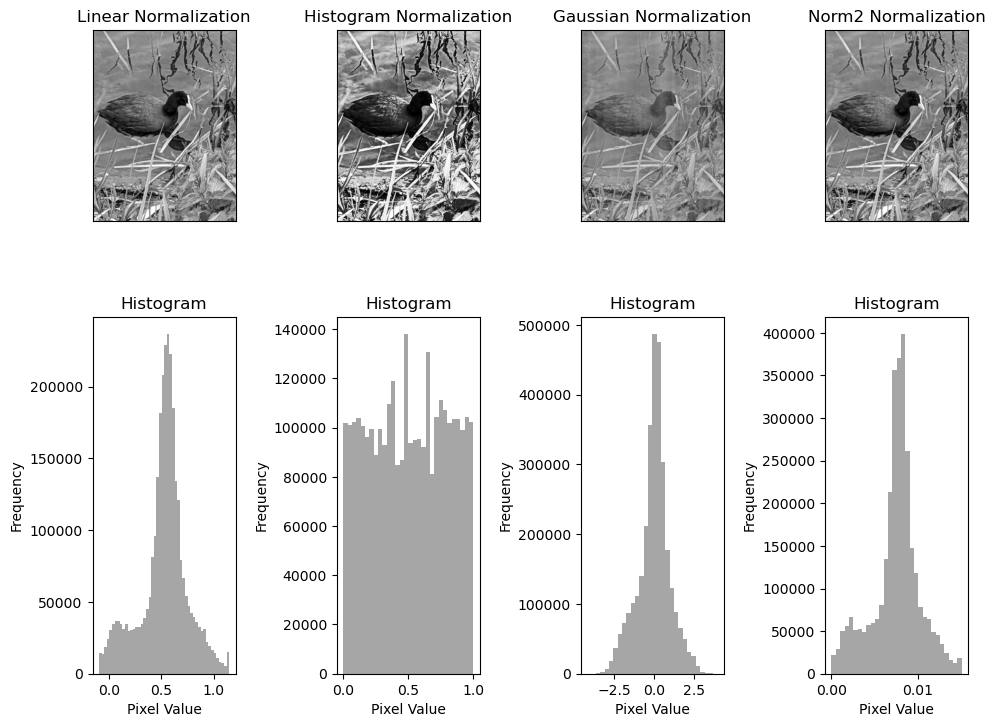

In [22]:
# Linear Normalization
ln = linear_normalization(g2)
print(type(ln))
f_img = flatten_image(ln)

# Histogram Normalization
histo_norm = histogram_normalization(g2)
print(type(histo_norm))
f_img_hn = flatten_image(histo_norm)

# Gaussian Normalization
gn = gaussian_normalization(g2)
print(type(gn))
f_img_gn = flatten_image(gn)

# Norm2 Normalization
n2n = norm2_normalization(g2)
print(type(n2n))
f_img_n2n = flatten_image(n2n)

# Create a figure and axes for subplots
fig, axes = plt.subplots(2, 4, figsize=(10, 8))

# Plot each image on its corresponding subplot and turn off axis labels
axes[0, 0].imshow(ln, cmap='gray')
axes[0, 0].set_title('Linear Normalization')
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])

# Plot histogram
axes[1, 0].hist(f_img, bins=50, range=(min(f_img), max(f_img)), color='gray', alpha=0.7)
axes[1, 0].set_title('Histogram')
axes[1, 0].set_xlabel('Pixel Value')
axes[1, 0].set_ylabel('Frequency')

axes[0, 1].imshow(histo_norm, cmap='gray')
axes[0, 1].set_title('Histogram Normalization')
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])

# Plot histogram
axes[1, 1].hist(f_img_hn, bins=30, range=(min(f_img_hn), max(f_img_hn)), color='gray', alpha=0.7)
axes[1, 1].set_title('Histogram')
axes[1, 1].set_xlabel('Pixel Value')
axes[1, 1].set_ylabel('Frequency')

axes[0, 2].imshow(gn, cmap='gray')
axes[0, 2].set_title('Gaussian Normalization')
axes[0, 2].set_xticks([])
axes[0, 2].set_yticks([])

# Plot histogram
axes[1, 2].hist(f_img_gn, bins=30, range=(min(f_img_gn), max(f_img_gn)), color='gray', alpha=0.7)
axes[1, 2].set_title('Histogram')
axes[1, 2].set_xlabel('Pixel Value')
axes[1, 2].set_ylabel('Frequency')

axes[0, 3].imshow(n2n, cmap='gray')
axes[0, 3].set_title('Norm2 Normalization')
axes[0, 3].set_xticks([])
axes[0, 3].set_yticks([])
# Plot histogram
axes[1, 3].hist(f_img_n2n, bins=30, range=(min(f_img_n2n), max(f_img_n2n)), color='gray', alpha=0.7)
axes[1, 3].set_title('Histogram')
axes[1, 3].set_xlabel('Pixel Value')
axes[1, 3].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.savefig("Additional-normalizations.jpeg")

# Display the plot
plt.show()



In [ ]:
#https://commons.wikimedia.org/wiki/File:Building_-_Monochrome_-_Black_and_White.jpg
